# import lib

In [17]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

from skimage.io import imread, imshow, imsave, imread_collection, concatenate_images
from skimage.transform import resize

%matplotlib inline
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Configurations

In [162]:
class BowlConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Bowl"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    USE_MINI_MASK = False
    
config = BowlConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           Bowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_PO

# Dataset

In [163]:
class BowlDataset(utils.Dataset):
    def __init__(self):
        super(BowlDataset, self).__init__()
        self.add_class("shapes", 1, "nuclei")
        self.TRAIN_PATH = '../format_train/'
        train_ids = next(os.walk(self.TRAIN_PATH))[1]
        
        for n, id_ in enumerate(train_ids):
            path = os.path.join(self.TRAIN_PATH, id_, 'images', id_+'.png')
            self.add_image("shapes", image_id=n, path=path, id_=id_)
            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        id_ = info['id_']
        path = os.path.join(self.TRAIN_PATH, id_)
        mask_files = next(os.walk(path + '/masks/'))[2]
        mask_count = len(mask_files)
        masks = np.zeros([256, 256, mask_count], dtype=np.uint8)
        for i, mask_file in enumerate(mask_files):
            masks[:, :, i:i+1] = np.expand_dims(imread(path + '/masks/' + mask_file), axis=-1)
        
        class_ids = np.array([1]*mask_count)
        return masks, class_ids

In [164]:
dataset_train = BowlDataset()
dataset_train.prepare()

dataset_validate = BowlDataset()
dataset_validate.prepare()

# have a look at data

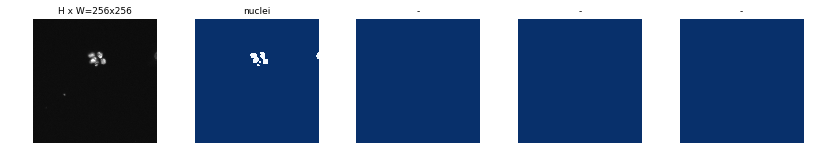

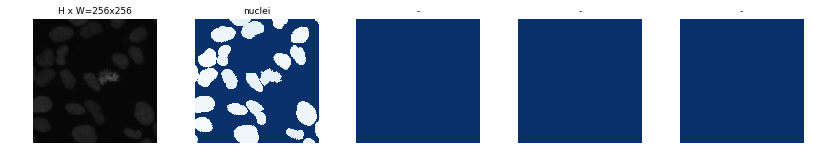

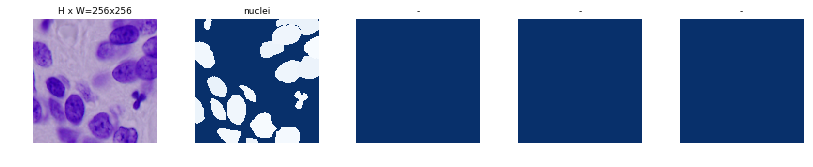

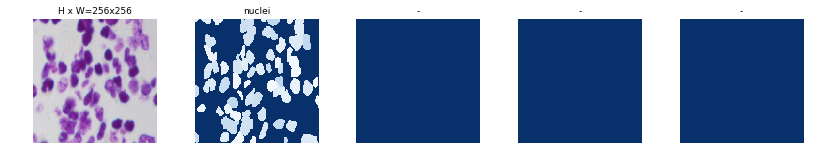

In [165]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# create model

In [195]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [196]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

# Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [197]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='all')


Starting at epoch 7. LR=0.001

Checkpoint Path: /home/pzy/kaggle/2018Bowl/Mask_RCNN/logs/bowl20180207T2121/mask_rcnn_bowl_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)


/home/pzy/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/pzy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a_branch1           (BatchNorm)
res3b_branch2a         (Conv2D)
bn3b_branch2a          (BatchNorm)
res3b_branch2b         (Conv2D)
bn3b_branch2b          (BatchNorm)
res3b_branch2c         (Conv2D)
bn3b_branch2c          (BatchNorm)
res3c_branch2a         (Conv2D)
bn3c_branch2a          (BatchNorm)
res3c_branch2b         (Conv2D)
bn3c_branch2b          (BatchNorm)
res3c_branch2c         (Con

 84/100 [========================>.....] - ETA: 2:47 - loss: 1.0504 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.4126 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.2353

KeyboardInterrupt: 

# Detection

In [198]:
class InferenceConfig(BowlConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/pzy/kaggle/2018Bowl/Mask_RCNN/logs/bowl20180207T2121/mask_rcnn_bowl_0006.h5


image_id 227
original_image           shape: (256, 256, 3)         min:    2.00000  max:  139.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (44,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (44, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 44)        min:    0.00000  max:  255.00000


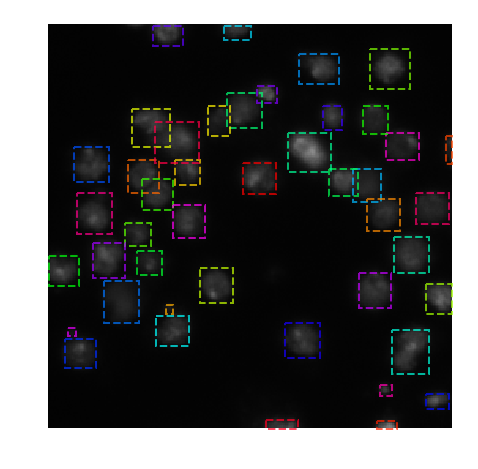

In [211]:
# Test on a random image
image_id = random.choice(dataset_validate.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

print("image_id", image_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  139.00000
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:   35.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


/home/pzy/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pzy/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


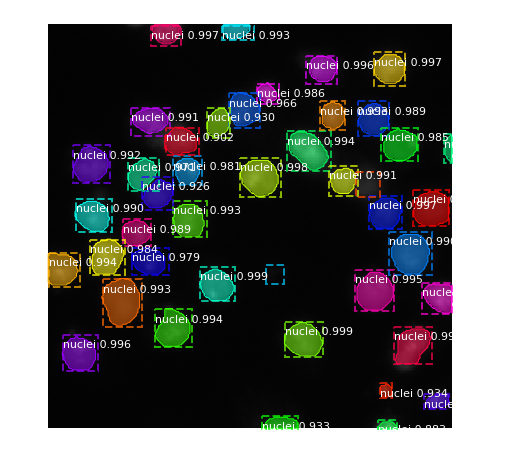

In [212]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax(), score_threshold=0.8)

# encode and submit results

In [190]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    for i in range(0, len(run_lengths), 2):
        if (run_lengths[i]+run_lengths[i+1]) > (x.shape[0])*(x.shape[1]):
            print('assert', run_lengths[i], run_lengths[i+1], (x.shape[0])*(x.shape[1]))
#             run_lengths[i+1] = run_lengths[i+1]-8
#         assert((run_lengths[i]+run_lengths[i+1]) < (x.shape[0])*(x.shape[1]))
    return run_lengths

In [191]:
TEST_PATH = '../stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

rles = []
new_test_ids = []
for n, id_ in enumerate(test_ids):
# for id_ in ['fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3']:
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    org_size = (img.shape[0], img.shape[1])
#     print('orginal size:', org_size)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    results = model.detect([img], verbose=1)
    r = results[0]
    
#     visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_validate.class_names, r['scores'], ax=get_ax(), score_threshold=0.5)

    mask = r['masks']
    bboxes = r['rois']
#     print('mask shape:', mask.shape)
    mm = np.ones(org_size)
    for i in range(mask.shape[2]):
        m = np.squeeze(mask[:, :, i:i+1])
        om = resize(m, org_size, mode='constant', preserve_range=True)
        om = (om>0)
#         print(np.array_equal(np.where(om!=0), np.where(omm==1)))
        om = np.logical_and(om, mm)
#         print('om shape', om.shape)
        rle = rle_encoding(om)
        if len(rle) == 0:
            continue
        rles.append(rle)
        new_test_ids.append(id_)
        mm = mm - om
#         plt.imshow(mm)
    
#     if n >= 2:
#         break

print('rles length:', len(rles))
print('new_test_ids length:', len(new_test_ids))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    5.04688  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -118.65313  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


/home/pzy/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pzy/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Processing 1 images
image                    shape: (256, 256, 3)         min:   27.55714  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min:  -96.14286  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  195.36938
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   91.46938
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    3.83875  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -119.86125  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  159.75000
molded_images            shape: (1, 256, 256, 3)  

Processing 1 images
image                    shape: (256, 256, 3)         min:    4.16994  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -119.53006  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   11.09253  max:  223.17114
molded_images            shape: (1, 256, 256, 3)      min: -112.60747  max:  119.27114
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   95.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:   -8.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)  

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   93.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  -10.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   11.01562  max:  229.11816
molded_images            shape: (1, 256, 256, 3)      min: -112.68438  max:  125.21816
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.05074  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.64926  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000
molded_images            shape: (1, 256, 256, 3)  

In [193]:
# Create submission DataFrame
import pandas as pd
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../sub-dsbowl2018-mask-3.csv', index=False)